# Data processing

### Load libraries

In [47]:
import pandas as pd
import numpy as np
import time
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import contractions
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load data and preprocess

In [48]:
# Load dataframes
df_politics_Israel = pd.read_csv('data/politics_Israel_comments.csv')
df_politics_Palestine = pd.read_csv('data/politics_Palestine_comments.csv')
df_worldnews_Israel = pd.read_csv('data/worldnews_Israel_comments.csv')
df_worldnews_Palestine = pd.read_csv('data/worldnews_Palestine_comments.csv')
df_Israel_Israel = pd.read_csv('data/Israel_Israel_comments.csv')
df_Israel_Palestine = pd.read_csv('data/Israel_Palestine_comments.csv')
df_Palestine_Israel = pd.read_csv('data/Palestine_Israel_comments.csv')
df_Palestine_Palestine = pd.read_csv('data/Palestine_Palestine_comments.csv')
df_baking = pd.read_csv('data/baking_cake_comments.csv')

# Concatenate the DataFrames
df_combined = pd.concat([
    df_politics_Israel, df_politics_Palestine, 
    df_worldnews_Israel, df_worldnews_Palestine, 
    df_Israel_Israel, df_Israel_Palestine, 
    df_Palestine_Israel, df_Palestine_Palestine,
    df_baking
])

# Print initial shape
print(f"Combined DataFrame shape before processing: {df_combined.shape}")

# Store original text in a new column for reference
df_combined['comment_original'] = df_combined['comment_text']

# Remove duplicate comments based on 'comment_text'
df_combined = df_combined.drop_duplicates(subset='comment_text')

# Remove comments with 1 or fewer upvotes
df_combined = df_combined[df_combined['upvotes'] > 1]

# Remove URLs
df_combined['comment_text'] = df_combined['comment_text'].apply(lambda x: re.sub(r'http\S+|www.\S+', '', x))

# Expand contractions
df_combined['comment_text'] = df_combined['comment_text'].apply(lambda x: contractions.fix(x))

# Lowercase conversion
df_combined['comment_text'] = df_combined['comment_text'].str.lower()

# Remove special characters except ".", "!","?", and ","
df_combined['comment_text'] = df_combined['comment_text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9.,!?]', ' ', x))

# Remove rows where comments contains no letters
df_combined = df_combined[df_combined['comment_text'].str.contains(r'[a-zA-Z]', regex=True)]

# Renaming
df_combined.rename(columns={'comment_text': 'comment_processed'}, inplace=True)

# Remove row if processed text is below 4 words
df_combined = df_combined[df_combined['comment_processed'].apply(lambda x: len(x.split()) > 3)]

# Remove whitespaces and multiple spaces
df_combined['comment_processed'] = df_combined['comment_processed'].str.strip().str.replace(r'\s+', ' ', regex=True)

# New column without stopwords
stop_words = set(stopwords.words('english'))

df_combined['comment_no_stopwords'] = df_combined['comment_processed'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words])
)

# Reorder columns
df_combined = df_combined[['created_date', 'subreddit_id', 'search_query', 'post_id', 'comment_id', 
                           'post_title', 'comment_original', 'comment_processed', 'comment_no_stopwords', 'upvotes', 
                           'post_url', 'comment_url']]

# Remove row if there is an empty field
df_combined = df_combined.dropna()

# Reset index
df_combined.reset_index(drop=True, inplace=True)

# Print shape after processing
print(f"Combined DataFrame shape after processing: {df_combined.shape}")

# Display final DataFrame
df_combined.head(2)

Combined DataFrame shape before processing: (16585, 10)
Combined DataFrame shape after processing: (13317, 12)


,created_date,subreddit_id,search_query,post_id,comment_id,post_title,comment_original,comment_processed,comment_no_stopwords,upvotes,post_url,comment_url
0,2024-10-27 15:32:33,politics,Israel,1gdcy25,lu0s0st,Bernie Sanders to voters skipping presidential...,"News flash, Trump is worse on every single vot...","news flash, trump is worse on every single vot...","news flash, trump worse every single voting is...",8981,https://www.reddit.com/r/politics/comments/1gd...,https://www.reddit.com/r/politics/comments/1gd...
1,2024-10-27 15:08:10,politics,Israel,1gdcy25,lu0nkvc,Bernie Sanders to voters skipping presidential...,Protest non-voters are some of the worst type ...,protest non voters are some of the worst type ...,protest non voters worst type privileged peopl...,4186,https://www.reddit.com/r/politics/comments/1gd...,https://www.reddit.com/r/politics/comments/1gd...


Example to compare original comment with processed comment

In [49]:
# print out a comment URL and text
print(df_combined['comment_url'].iloc[0])
print(df_combined['comment_original'].iloc[0])
print(df_combined['comment_processed'].iloc[0])
print(df_combined['comment_no_stopwords'].iloc[0])

https://www.reddit.com/r/politics/comments/1gdcy25/bernie_sanders_to_voters_skipping_presidential/lu0s0st
News flash, Trump is worse on every single voting issue. Every. Single. One.
news flash, trump is worse on every single voting issue. every. single. one.
news flash, trump worse every single voting issue. every. single. one.


### Apply sentiment and Lix

In [ ]:
%run sentiment_analysis.ipynb
%run lix_calc_function.ipynb

#Apply function LIX calculation
df_combined['lix_score'] = df_combined['comment_processed'].apply(lix_calc_used)

# Apply function to calculate sentiment score
df_combined['sentiment_score'] = df_combined['comment_processed'].apply(calculate_sentiment_vader)

# Apply log transformation to upvotes
df_combined['log_upvotes'] = df_combined['upvotes'].apply(lambda x: np.log(x))

# Apply log transformation to lix_score
df_combined['log_lix_score'] = df_combined['lix_score'].apply(lambda x: np.log(x))

Plot the distributions
---


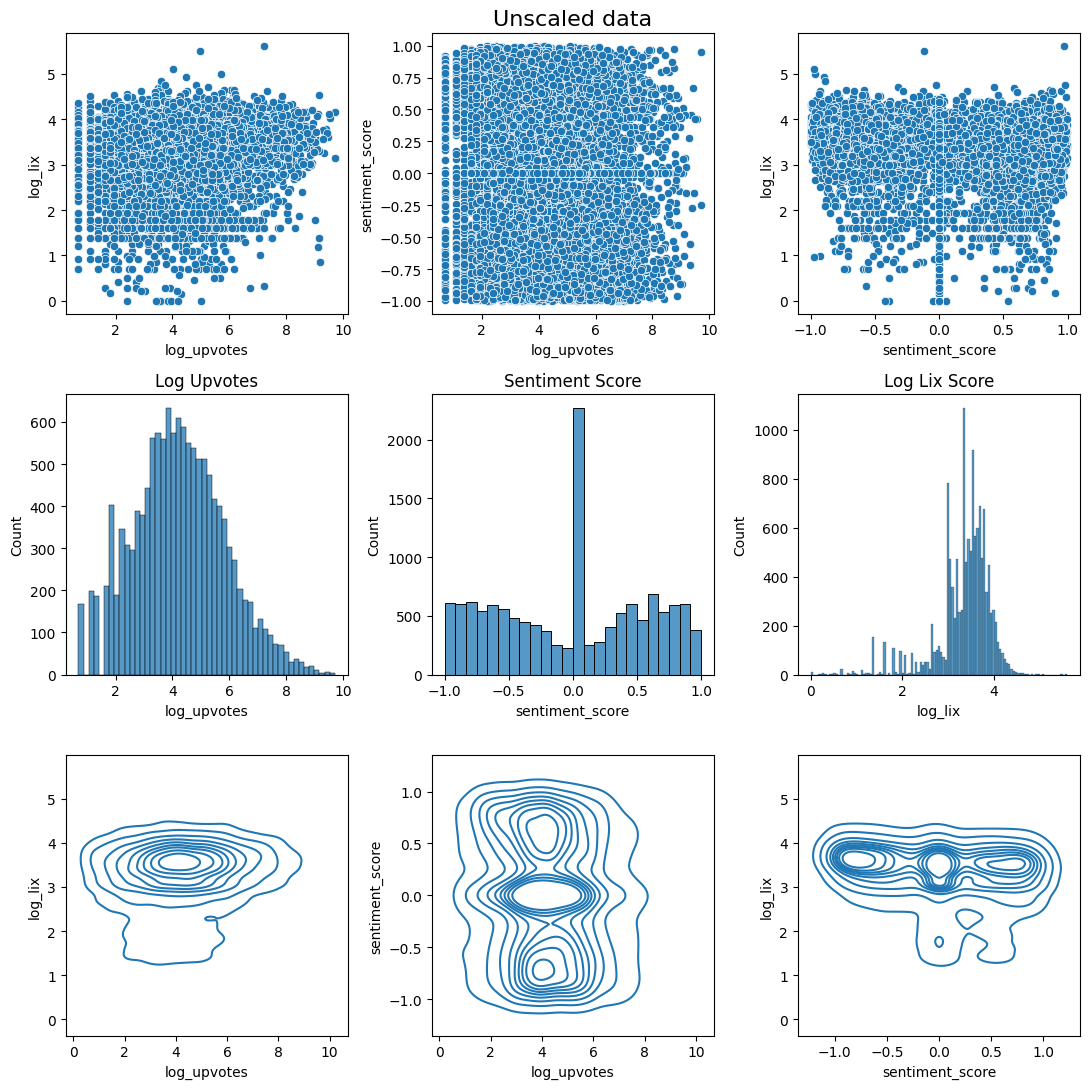

In [ ]:
dt = df_combined.copy()

fig, axes = plt.subplots(3, 3, figsize=(11, 11))
cols = ['log_upvotes', 'log_lix_score', 'sentiment_score']
df_clean = dt[cols]

axes[0, 1].set_title('Unscaled data', fontsize=16)
sns.scatterplot(ax = axes[0, 0], data=df_clean, x="log_upvotes", y="log_lix_score")
sns.scatterplot(ax = axes[0, 1], data=df_clean, x="log_upvotes", y="sentiment_score")
sns.scatterplot(ax = axes[0, 2], data=df_clean, x="sentiment_score", y="log_lix_score")

sns.histplot(ax = axes[1,0], data=dt, x="log_upvotes").set_title('Log Upvotes')
sns.histplot(ax = axes[1,1], data=dt, x="sentiment_score").set_title('Sentiment Score')
sns.histplot(ax = axes[1,2], data=dt, x="log_lix_score").set_title('Log Lix Score')

sns.kdeplot(ax = axes[2, 0], data=df_clean, x="log_upvotes", y="log_lix_score", )
sns.kdeplot(ax = axes[2, 1], data=df_clean, x="log_upvotes", y="sentiment_score")
sns.kdeplot(ax = axes[2, 2], data=df_clean, x="sentiment_score", y="log_lix_score")

plt.tight_layout()
plt.show()

# Export dataframes

In [27]:
# Now we export them to CSV
subreddits = df_combined['subreddit_id'].unique()
for subreddit in subreddits:
    df_combined[df_combined['subreddit_id'] == subreddit].to_csv(f'data/{subreddit}_w_lix_sentiment.csv', index=False)